# Radiance Field Reconstruction (NeRF-like)

In this tutorial, we will learn how to implement a 3D scene reconstruction pipeline similar to the one presented in the following work: [ReLU Fields: The Little Non-linearity That Could][1]. This simple [NeRF][2]-like method reconstructs the radiance field of a scene without the use of any neural networks or sparse data structures. It models a scene as a purely emissive volume with a directionally varying emission. The volume density is modeled by interpolated 3D grid values that are passed through a fixed non-linearity (ReLU) to boost sharpness. The view-dependent appearance is represented using spherical harmonics (SH), with coefficients stored on a regular grid. For a given ray, the outgoing radiance is evaluated using ray marching. By differentiating through the ray marching routine, the density and SH coefficients can be fit to a set of reference images. 

This algorithm is simple and surprisingly powerful, and very easy to implement using the built-in functionality of Mitsuba and Dr.Jit.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Implement a custom adjoint PRB-style integrator</li>
  <li>Use the Dr.Jit's spherical harmonics routines</li>
  <li>Schedule up-scaling of the optimized voxel grids during the optimization</li>
</ul>
    
</div>

[1]: https://geometry.cs.ucl.ac.uk/group_website/projects/2022/relu_fields/
[2]: https://www.matthewtancik.com/nerf

## Setup
As usual, we first import Mitsuba and Dr.Jit and set a variant that supports automatic differentiation.

In [1]:
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

For convenience, we define a helper function to plot a list of images in one row:

In [2]:
import matplotlib.pyplot as plt
def plot_list(images, title=None):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 3))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')
    if title is not None:
        plt.suptitle(title)

## Parameters

We now define a few parameters for the optimization pipeline implemented below. The optimization will start at a low resolution and then upsample the optimized volume parameters every `num_iterations_per_stage` iterations. This will be done a total of `num_stages` times. This coarse-to-fine scheme improves convergence and is a common heuristic used in differentiable rendering.

In [3]:
# Rendering resolution
render_res = 256

# Number of stages
num_stages = 4

# Number of training iteration per stage
num_iterations_per_stage = 15

# learning rate 
learning_rate = 0.2

# Initial grid resolution
grid_init_res = 16

# Spherical harmonic degree to be use for view-dependent appearance modeling
sh_degree = 2

# Enable ReLU in integrator
use_relu = True

# Number of sensors
sensor_count = 7

In [4]:
# IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
import os
if 'PYTEST_CURRENT_TEST' in os.environ:
    num_stages = 2
    num_iterations_per_stage = 2
    render_res = 8
    sensor_count = 3

## Creating multiple sensors

As done in many of the other tutorials, we instantiate a couple of sensors to render our synthetic scene from different viewpoints. Here the cameras are placed in a circle around the `[0.5, 0.5, 0.5]` point which is going to be the center of our voxel grids.

In [5]:
sensors = []

for i in range(sensor_count):
    angle = 360.0 / sensor_count * i
    sensors.append(mi.load_dict({
        'type': 'perspective', 
        'fov': 45, 
        'to_world': mi.ScalarTransform4f().translate([0.5, 0.5, 0.5]) \
                                        .rotate([0, 1, 0], angle)   \
                                        .look_at(target=[0, 0, 0], 
                                                 origin=[0, 0, 1.3], 
                                                 up=[0, 1, 0]),
        'film': {
            'type': 'hdrfilm', 
            'width': render_res, 
            'height': render_res, 
            'filter': {'type': 'box'}, 
            'pixel_format': 'rgba'
        }
    }))

## Rendering synthetic reference images

For this tutorial we will attempt to reconstruct a synthetic 3D scene also used in the other related works. We load the scene and render the reference images for all different viewpoints. **NOTE**: Please ignore the "Download data" button at the top of this page. This example requires the following different [scene file](http://rgl.s3.eu-central-1.amazonaws.com/scenes/lego.zip).

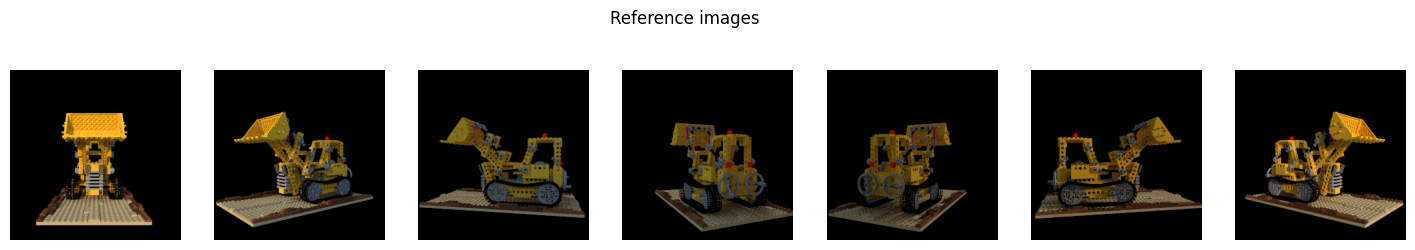

In [6]:
scene_ref = mi.load_file('../scenes/lego/scene.xml')
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=64) for i in range(sensor_count)]
plot_list(ref_images, 'Reference images')

## NeRF-like PRB integrator

Unlike the other tutorials, this pipeline doesn't use any of the conventional physically-based rendering algorithms such as path-tracing. Instead, it implements a differentiable integrator for emissive volumes that directly uses a density and SH coefficient grid.

We define an integrator `RadianceFieldPRB` that inherits from `mi.ad.common.RBIntegrator`. The `RBIntegrator` class is meant to be used to implement differentiable integrators 
that rely on tracing light paths to estimate derivatives (in contrast to purely using automatic differentiation). In the Mitsuba code base, this integrator base class is primarily used to implement various versions of [path replay backpropagation][1]. 

In the following implementation, we use this interface to implement a differentiable rendering method for purely emissive volumes (we don't consider scattering or indirect effects). We will use the path replay algorithm to implement a ray marching routine that does not need to allocate any large temporary buffers to differentiate the rendering process. This means that the memory use of this implementation will only depend on the size of the parameter grids, and not on the number of rays being evaluated at once.

We implement the functions `__init__`, `eval_emission` `sample`, `traverse` and `parameters_changed`.

In `__init__` we initialize a bounding box for our volume as well as 3D textures storing the density (`sigmat`) and SH coefficients (`sh_coeffs`). The number of channels for the SH coefficients depends on the chosen `sh_degree` (default: `2`). 

The `traverse` function simply returns the differentiable parameters and `parameters_changed` updates the 3D textures in case the differentiable parameters were updated (e.g., by a gradient step). The update of the 3D textures is necessary for Mitsuba variants where hardware-accelerated texture interpolation is used (i.e., `cuda_ad_rgb`). By invoking `texture.set_tensor(texture.tensor())`, we force Dr.Jit to update the underlying hardware texture.

The main ray marching implementation is inside the `sample` function. This function returns the radiance along a single input ray. We first check if the ray intersects the volume's bounding box. We then use an `mi.Loop` to perform the ray marching routine. Inside the loop, we evaluate the density and spherical harmonics coefficients at the current point `p`. We accumulate radiance in a variable `L` and use `β` to store the current throughput. The directionally varying emission is evaluated using the `eval_emission` helper function. 

The `sample` function is written such that it can both be used for the primal computation (`primal = True`) and to accumulate gradients in reverse mode (`primal = False`). 

When computing the parameter gradients, we pass the gradient of the objective function (`δL`) and the output of the primal computation (`state_in`). Instead of accumulating radiance in the variable `L`, we initialize `L` from the primal output and then iteratively *subtract* emitted radiance to reconstruct gradient values. The `dr.backward_from` call backpropagates gradients all the way to the two 3D textures.

In reverse mode, a significant part of the computation inside the loop is evaluated with gradients enabled. The `dr.resume_grad` scope enables gradients selectively inside the `with` block. The algorithm is designed to not build any AD graph across loop iterations.

For a more detailed explanation of path replay, please see the [paper][1].


[1]: http://rgl.epfl.ch/publications/Vicini2021PathReplay

In [7]:
class RadianceFieldPRB(mi.python.ad.integrators.common.RBIntegrator):
    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.bbox = mi.ScalarBoundingBox3f([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
        self.use_relu = use_relu
        self.grid_res = grid_init_res
        # Initialize the 3D texture for the density and SH coefficients
        res = self.grid_res
        self.sigmat = mi.Texture3f(dr.full(mi.TensorXf, 0.01, shape=(res, res, res, 1)))
        self.sh_coeffs = mi.Texture3f(dr.full(mi.TensorXf, 0.1, shape=(res, res, res, 3 * (sh_degree + 1) ** 2)))

    def eval_emission(self, pos, direction): 
        spec = mi.Spectrum(0)
        sh_dir_coef = dr.sh_eval(direction, sh_degree)
        sh_coeffs = self.sh_coeffs.eval(pos)
        for i, sh in enumerate(sh_dir_coef):
            spec += sh * mi.Spectrum(sh_coeffs[3 * i:3 * (i + 1)])
        return dr.clip(spec, 0.0, 1.0)

    @dr.syntax
    def sample(self, mode, scene, sampler,
               ray, δL, state_in, active, **kwargs):
        primal = mode == dr.ADMode.Primal
        
        ray = mi.Ray3f(ray)
        hit, mint, maxt = self.bbox.ray_intersect(ray)
        
        active = mi.Bool(active)
        active &= hit  # ignore rays that miss the bbox
        if not primal:  # if the gradient is zero, stop early
            active &= dr.any(δL != 0)

        step_size = mi.Float(1.0 / self.grid_res)
        t = mi.Float(mint) + sampler.next_1d(active) * step_size
        L = mi.Spectrum(0.0 if primal else state_in)
        δL = mi.Spectrum(δL if δL is not None else 0)
        β = mi.Spectrum(1.0) # throughput
                
        while active:
            p = ray(t)
            with dr.resume_grad(when=not primal):
                sigmat = self.sigmat.eval(p)[0]
                if self.use_relu:
                    sigmat = dr.maximum(sigmat, 0.0)
                tr = dr.exp(-sigmat * step_size)
                # Evaluate the directionally varying emission (weighted by transmittance)
                Le = β * (1.0 - tr) * self.eval_emission(p, ray.d) 

            β *= tr
            L = L + Le if primal else L - Le

            with dr.resume_grad(when=not primal):
                if not primal:
                    dr.backward_from(δL * (L * tr / dr.detach(tr) + Le))

            t += step_size
            active &= (t < maxt) & dr.any(β != 0.0)


        return L if primal else δL, mi.Bool(True), [], L

    def traverse(self, callback):
        callback.put_parameter("sigmat", self.sigmat.tensor(), mi.ParamFlags.Differentiable)
        callback.put_parameter('sh_coeffs', self.sh_coeffs.tensor(), mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        self.sigmat.inplace_update()
        self.sh_coeffs.inplace_update()
        self.grid_res = self.sigmat.shape[0]

mi.register_integrator("rf_prb", lambda props: RadianceFieldPRB(props))

## Setting up the optimization scene

Here we set up our simple optimization scene. It is only composed of a constant area light and a `RadianceFieldPRB` integrator. No geometry or volume instance is needed since the integrator itself already contains the feature voxel grid.

As shown in the rendered initial state, the scene appears empty at first as the density grid was initialized with a very low density value.

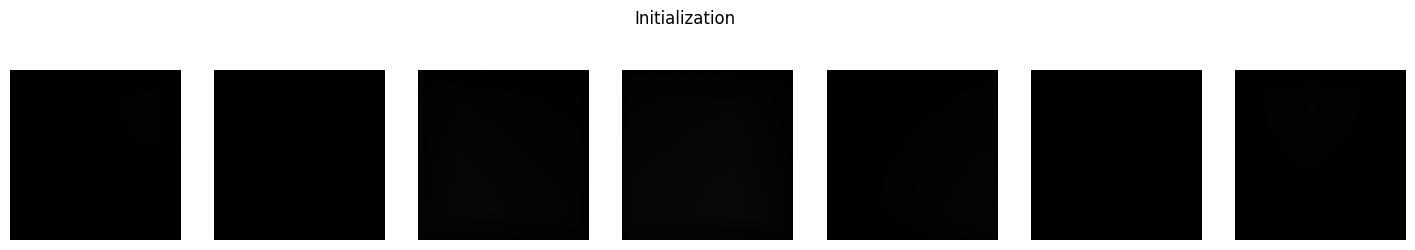

In [8]:
scene = mi.load_dict({
    'type': 'scene', 
    'integrator': {
        'type': 'rf_prb'
    }, 
    'emitter': {
        'type': 'constant'
    }
})
integrator = scene.integrator()

# Render initial state
init_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]
plot_list(init_images, 'Initialization')

## Optimization

We use an `Adam` optimizer in this pipeline. The constructor of the optimizer takes the learning rate as well as a dictionary of optimized variables. In this tutorial, we want to optimize the density and spherical harmonics coefficients grids. We call `params.update(opt)` to ensure that the integrator is notified that some parameters now have gradients enabled.

In [9]:
params = mi.traverse(integrator)
opt = mi.ad.Adam(lr=learning_rate, params={'sigmat': params['sigmat'], 'sh_coeffs': params['sh_coeffs']})
params.update(opt);

Finally comes the main optimization loop of the pipeline. As in previous tutorials, at every iteration we render the scene from the different viewpoints and back-propagate the gradients through an L1 loss.

For convenience we store intermediate renderings at the end of every stage to further inspect the optimization progress.

Moreover, as stated earlier in this tutorial, we up-sample the feature voxel grids by a factor of two at the end of every stage. This can easily be achieved using the [<code>dr.resample()</code>][1] routine.

[1]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.resample

In [10]:
losses = []
intermediate_images = []

for stage in range(num_stages):
    print(f"Stage {stage+1:02d}, feature voxel grids resolution -> {opt['sigmat'].shape[0]}")
    
    for it in range(num_iterations_per_stage):
        total_loss = 0.0
        images = []
        for sensor_idx in range(sensor_count):
            img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=1, seed=it)
            loss = dr.mean(dr.abs(img - ref_images[sensor_idx]), axis=None)
            dr.backward(loss)
            total_loss += loss
            
            # Store images at the end of every stage
            if it == num_iterations_per_stage - 1:
                dr.eval(img)
                images.append(img)
            
        losses.append(total_loss.array[0])
        opt.step()

        if not integrator.use_relu:
            opt['sigmat'] = dr.maximum(opt['sigmat'], 0.0)
            
        params.update(opt)
        print(f"  --> iteration {it+1:02d}: error={total_loss}", end='\r')

    intermediate_images.append(images)
    
    # Upsample the 3D textures at every stage
    if stage < num_stages - 1: 
        new_res = 2 * opt['sigmat'].shape[0]
        new_shape = (new_res, new_res, new_res, 1)
        opt['sigmat'] = dr.resample(opt['sigmat'], new_shape, filter='box')
        new_shape = (new_res, new_res, new_res,  3 * (sh_degree + 1) ** 2)
        opt['sh_coeffs'] = dr.resample(opt['sh_coeffs'], new_shape, filter='box')
        params.update(opt)

print('')
print('Done')

Stage 01, feature voxel grids resolution -> 16
Stage 02, feature voxel grids resolution -> 32
Stage 03, feature voxel grids resolution -> 64
Stage 04, feature voxel grids resolution -> 128
  --> iteration 15: error=1.32513
Done


## Results

We render the final images at higher SPP and display the results at every stages as well as the reference images.

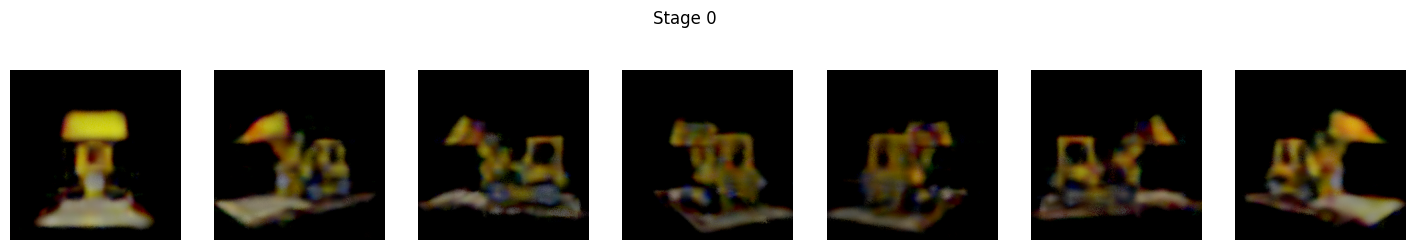

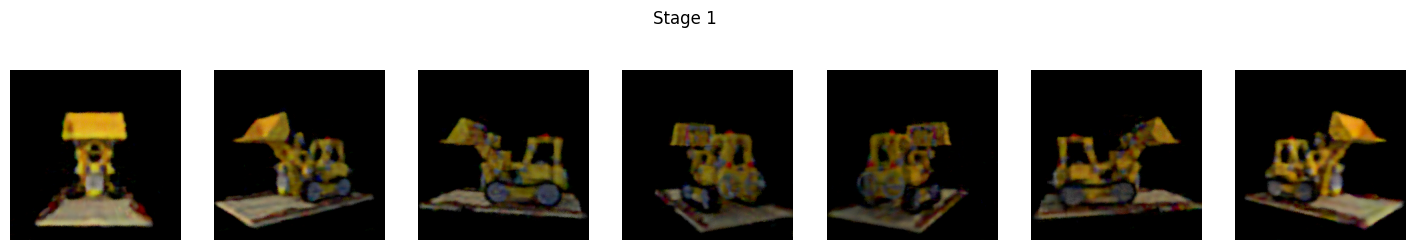

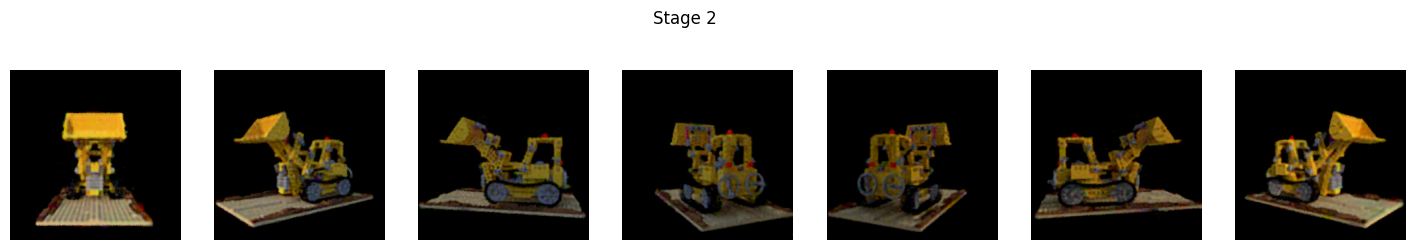

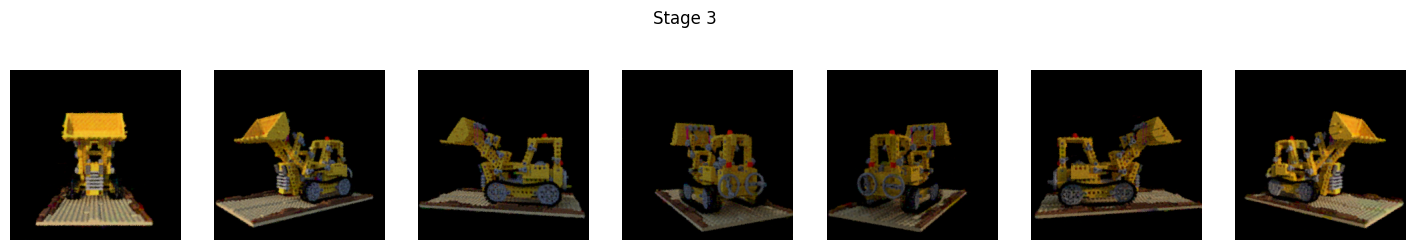

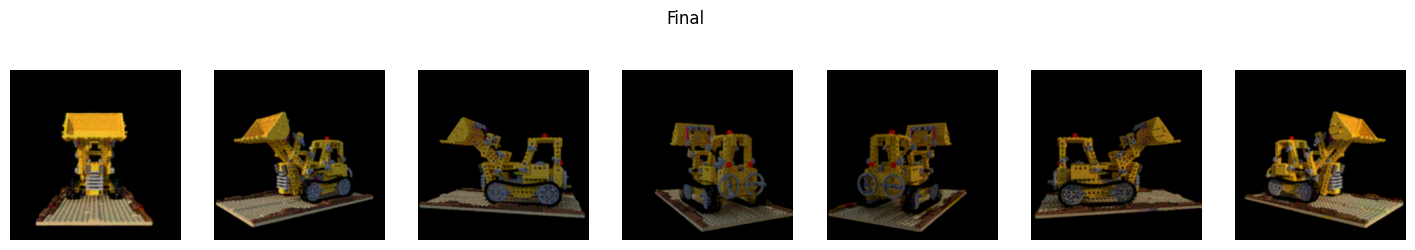

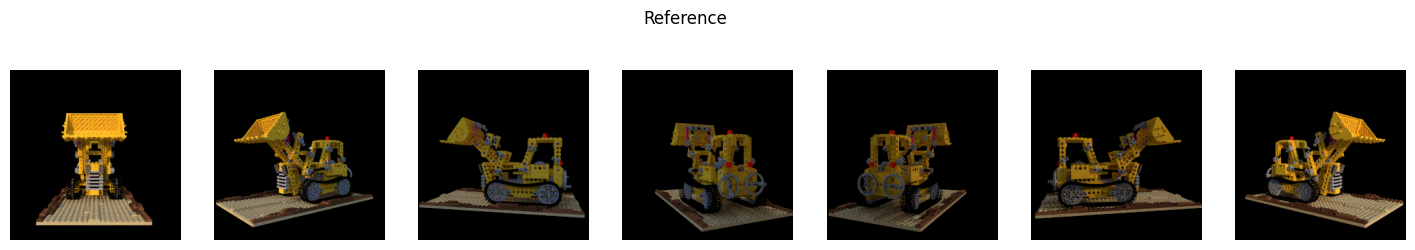

In [11]:
final_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]
for stage, inter in enumerate(intermediate_images):
    plot_list(inter, f'Stage {stage}')
plot_list(final_images, 'Final')
plot_list(ref_images, 'Reference')

We can also take a closer look at one of the view point:

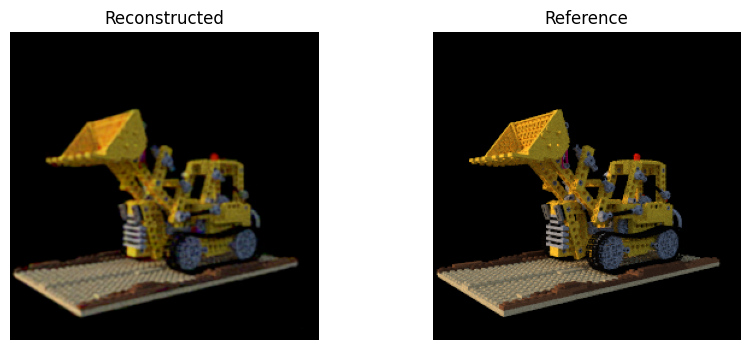

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(mi.util.convert_to_bitmap(final_images[1]))
axs[0].set_title('Reconstructed')
axs[0].axis('off')
axs[1].imshow(mi.util.convert_to_bitmap(ref_images[1]))
axs[1].set_title('Reference')
axs[1].axis('off');

When working with optimization pipelines, it is always very informative to take a look at the graph of objective function values.

Text(0, 0.5, 'Loss')

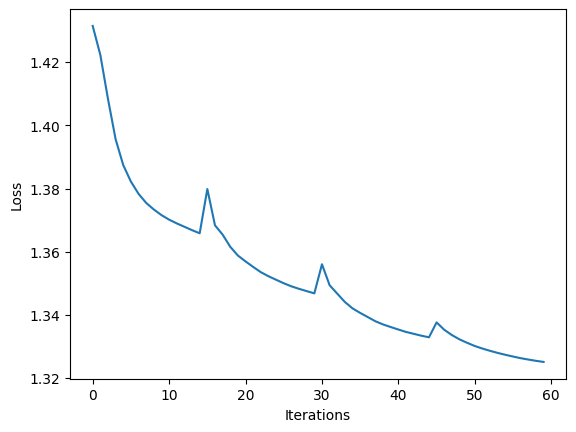

In [13]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

## See also

- [<code>mi.python.ad.integrators.common.RBIntegrator</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.RBIntegrator)
- [<code>mitsuba.TensorXf</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf)
- [<code>mitsuba.Texture3f</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Texture3f)
- [<code>dr.eval</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.eval)
- [<code>dr.resample</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.resample)